# Audience graph - link actors

Pairwise outlet similarities derived from users who tweet articles from domains.

In [1]:
import numpy as np
import pandas as pd
import torch
import random

from itertools import islice, combinations, chain
from tqdm import tqdm
from collections import defaultdict, Counter
from cached_property import cached_property
from scipy import random
from sklearn import preprocessing

from news_vec.utils import read_json_gz_lines
from news_vec import logger

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns

mpl.style.use('seaborn-muted')
sns.set(style="whitegrid")

%matplotlib inline

In [3]:
class Actors:
    
    def __init__(self, root, skim=None):
        self.root = root
        self.skim = skim
        
    def __iter__(self):
        reader = islice(read_json_gz_lines(self.root), self.skim)
        yield from tqdm(reader)

In [7]:
ac = Actors('../data/clf-actors.json/')

In [8]:
rows = [r for r in ac if random.random() < 0.1]

76224508it [03:22, 377034.87it/s]


In [9]:
len(rows)

7619568

In [10]:
ACTOR_DOMAINS = defaultdict(set)

for row in tqdm(rows):
    ACTOR_DOMAINS[row['actor_id']].add(row['domain'])

100%|██████████| 7619568/7619568 [00:17<00:00, 441966.55it/s]


In [11]:
ACTOR_DOMAINS_GT2 = {aid: ds for aid, ds in ACTOR_DOMAINS.items() if len(ds) > 1}

In [12]:
DOMAIN_COUNTS = Counter(chain(*[list(ds) for ds in ACTOR_DOMAINS_GT2.values()]))

In [13]:
DOMAINS, DOMAIN_COUNTS = zip(*DOMAIN_COUNTS.most_common())

In [14]:
DOMAIN_COUNTS_PRIOR = np.array(DOMAIN_COUNTS) / np.sum(DOMAIN_COUNTS)
DOMAIN_COUNTS_PRIOR = torch.from_numpy(DOMAIN_COUNTS_PRIOR).view(1, -1)

In [15]:
DOMAINS

('nytimes.com',
 'cnn.com',
 'washingtonpost.com',
 'thehill.com',
 'foxnews.com',
 'huffingtonpost.com',
 'wsj.com',
 'bloomberg.com',
 'apnews.com',
 'buzzfeed.com',
 'breitbart.com',
 'npr.org',
 'dailycaller.com',
 'dailykos.com',
 'rt.com',
 'sputniknews.com')

In [16]:
DOMAIN_COUNTS_PRIOR

tensor([[0.1443, 0.1347, 0.1270, 0.1181, 0.0677, 0.0653, 0.0497, 0.0457, 0.0454,
         0.0445, 0.0445, 0.0371, 0.0346, 0.0181, 0.0172, 0.0061]],
       dtype=torch.float64)

In [17]:
ACTOR_NUM_DOMAINS = [len(ds) for _, ds in ACTOR_DOMAINS_GT2.items()]
NUM_DOMAINS, NUM_DOMAINS_COUNT = zip(*Counter(ACTOR_NUM_DOMAINS).most_common())

In [18]:
NUM_DOMAINS_PRIOR = np.array(NUM_DOMAINS_COUNT) / np.sum(NUM_DOMAINS_COUNT)
NUM_DOMAINS_PRIOR = torch.from_numpy(NUM_DOMAINS_PRIOR).view(1, -1)

In [19]:
NUM_DOMAINS

(2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16)

In [20]:
NUM_DOMAINS_PRIOR

tensor([[4.6819e-01, 1.9614e-01, 1.0966e-01, 7.0859e-02, 4.8165e-02, 3.4682e-02,
         2.5132e-02, 1.7750e-02, 1.2194e-02, 8.5794e-03, 5.2062e-03, 2.3852e-03,
         7.9714e-04, 2.1247e-04, 4.1873e-05]], dtype=torch.float64)

In [27]:
def make_key(d1, d2):
    return tuple(sorted([d1, d2]))

In [21]:
OBSERVED_DOMAIN_PAIR_COUNTS = Counter()

for _, domains in tqdm(ACTOR_DOMAINS_GT2.items()):
    for d1, d2 in combinations(domains, 2):
        OBSERVED_DOMAIN_PAIR_COUNTS[make_key(d1, d2)] += 1

100%|██████████| 644804/644804 [00:05<00:00, 122286.06it/s]


In [26]:
SAMPLED_DOMAIN_PAIR_COUNTS = defaultdict(list)

for _ in tqdm(range(20)):
    
    # Sample actor -> num domains.
    ps = NUM_DOMAINS_PRIOR.repeat(len(ACTOR_DOMAINS_GT2), 1)
    nd_idxs = torch.multinomial(ps, 1)
    nds = [NUM_DOMAINS[i] for i in nd_idxs.view(-1).tolist()]
    
    counts = Counter()
    for nd, c in Counter(nds).items():
        
        # Sample actor -> domains.
        ps = DOMAIN_COUNTS_PRIOR.repeat(c, 1)
        domain_idxs = torch.multinomial(ps, nd)
        
        # Register counts.
        for idxs in domain_idxs.tolist():
            for i1, i2 in combinations(idxs, 2):
                key = make_key(DOMAINS[i1], DOMAINS[i2])
                counts[key] += 1
            
    # Register overall pair counts.
    for p, count in counts.items():
        SAMPLED_DOMAIN_PAIR_COUNTS[p].append(count)

100%|██████████| 20/20 [02:35<00:00,  7.75s/it]


In [28]:
sum(OBSERVED_DOMAIN_PAIR_COUNTS.values())

4427734

In [29]:
sum([cs[0] for _, cs in SAMPLED_DOMAIN_PAIR_COUNTS.items()])

4423600

In [34]:
rows = []
for pair, count in OBSERVED_DOMAIN_PAIR_COUNTS.items():
    sampled_counts = SAMPLED_DOMAIN_PAIR_COUNTS[pair]
    zscore = (count - np.mean(sampled_counts)) / np.std(sampled_counts)
    rows.append((*pair, zscore))

In [35]:
zdf = pd.DataFrame(rows, columns=('d1', 'd2', 'zscore'))
zdf.sort_values('zscore', ascending=False, inplace=True)

In [40]:
zdf['score'] = preprocessing.scale(zdf.zscore)
zdf['label'] = zdf[['d1', 'd2']].apply(lambda x: f'{x[0]} - {x[1]}', 1)

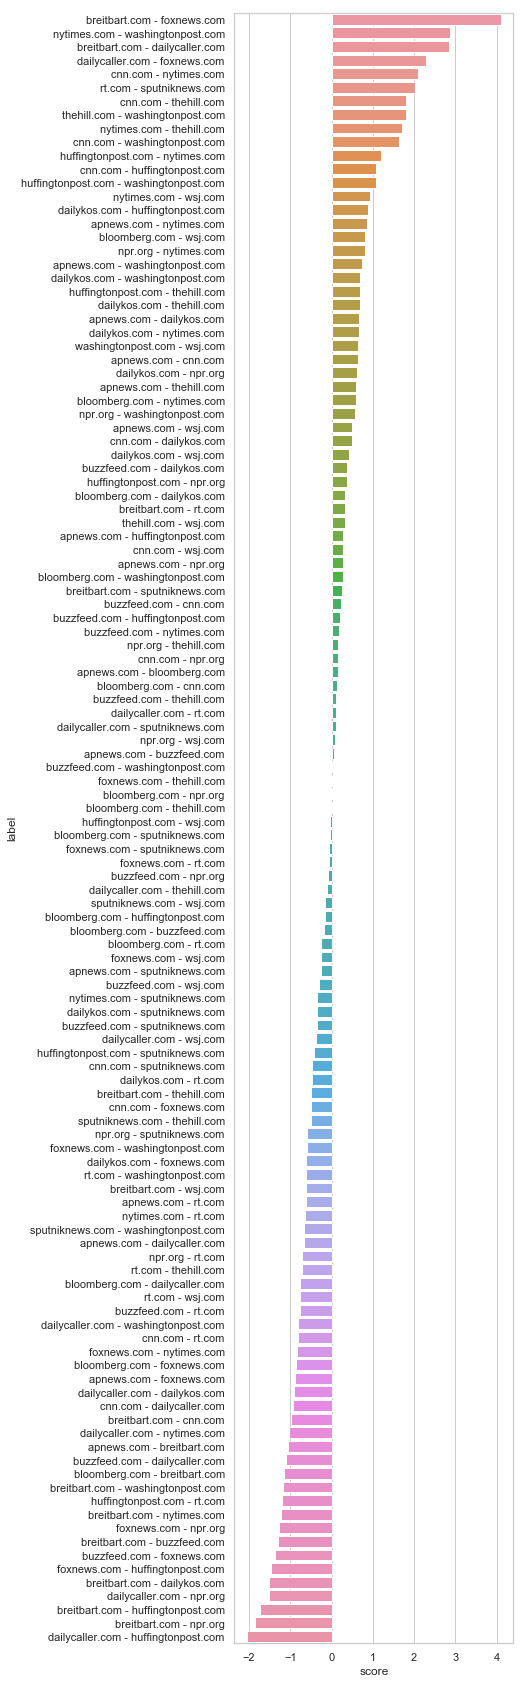

In [41]:
plt.figure(figsize=(5,30))
sns.barplot(x='score', y='label', data=zdf)